In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
 pip install keras-self-attention

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import gc
import seaborn as sns
import matplotlib.ticker as ticker
import tensorflow as tf
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout, TimeDistributed, Conv1D, Conv2D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Layer
from sklearn.preprocessing import MinMaxScaler
from keras_self_attention import SeqSelfAttention

**LOAD DATA**


In [ ]:
Header=[]
for i in range (1,9) :
  Header.append('Country'+ str(i))
#print(Header)

df = pd.read_csv('/content/drive/MyDrive/dataset/exchange_rate.csv', names=Header)
when = pd.date_range(start=pd.datetime(1990,1,1),freq='1D',periods=len(df))

df["Datetime"]=when
df=df.set_index('Datetime')

print(df.shape)
df.head()

(7588, 8)


<ipython-input-65-746bd346a793>:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  when = pd.date_range(start=pd.datetime(1990,1,1),freq='1D',periods=len(df))


,Country1,Country2,Country3,Country4,Country5,Country6,Country7,Country8
Datetime,,,,,,,,
1990-01-01,0.7855,1.6110,0.861698,0.634196,0.211242,0.006838,0.5930,0.525486
1990-01-02,0.7818,1.6100,0.861104,0.633513,0.211242,0.006863,0.5940,0.523972
1990-01-03,0.7867,1.6293,0.861030,0.648508,0.211242,0.006975,0.5973,0.526316
1990-01-04,0.7860,1.6370,0.862069,0.650618,0.211242,0.006953,0.5970,0.523834
1990-01-05,0.7849,1.6530,0.861995,0.656254,0.211242,0.006940,0.5985,0.527426


**DATA VISUALIZATION**

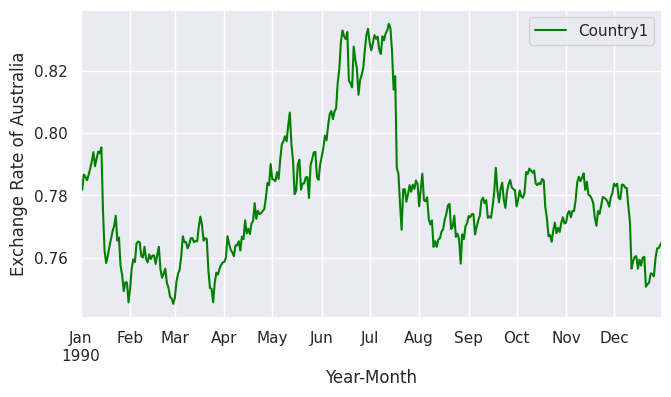

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(7.5,4)})

df.iloc[0:365].plot(y=['Country1'] ,color=['green'])

plt.ylabel('Exchange Rate of Australia')
plt.xlabel('Year-Month')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

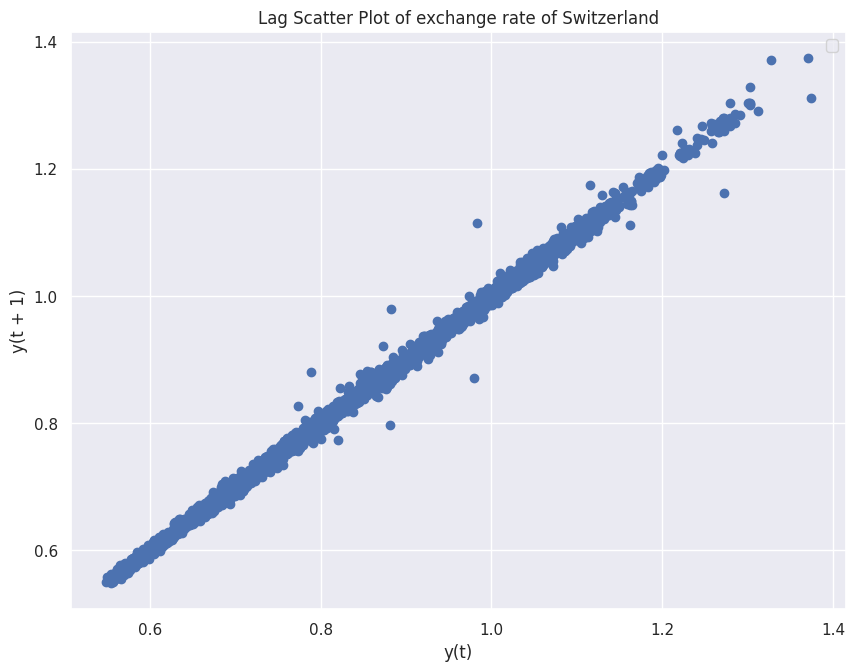

In [ ]:
from pandas.plotting import lag_plot

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(10,7.5)})

# lag scatter plot
lag_plot(df['Country4'])
plt.title('Lag Scatter Plot of exchange rate of Switzerland')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

[Text(0.5, 0, 'Years'),
 Text(0, 0.5, 'Exchange Rate'),
 Text(0.5, 1.0, 'Boxplots over each year for 16 years of Great Britain ')]

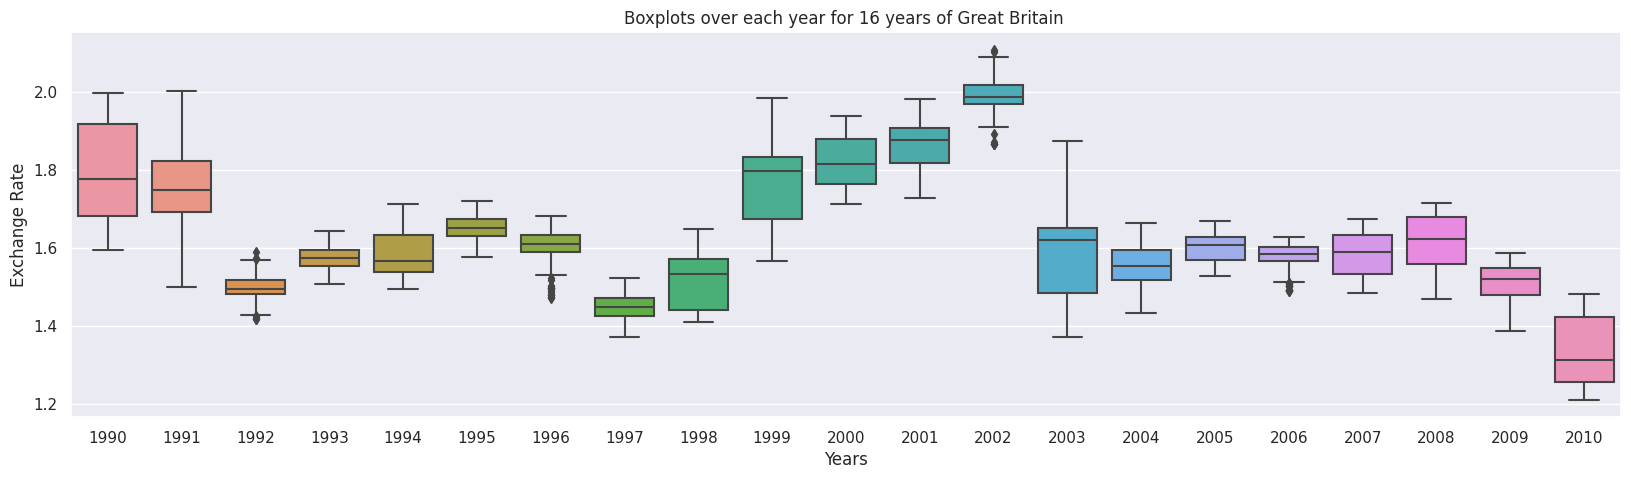

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
gfg = sns.boxplot(x = df.index.year,
                y = df['Country2'],
                ax = ax)
gfg.set(xlabel ="Years", ylabel = "Exchange Rate", title ='Boxplots over each year for 16 years of Great Britain ')

**MINMAX SCALING**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
dff = df
scalers={}
for i in df.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    s_s = scaler.fit_transform(dff[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    dff[i]=s_s

In [ ]:
def split_series(series, n_past, n_future):

  X, y = list(), list()
  print(len(series))
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future

    if future_end > len(series):
      break
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [ ]:
n_past = 24
n_future = 3
n_features = 8

**ADDITIVE DECOMPOSITION to COLLECT RESIDUALS**

In [ ]:
import statsmodels.api as sm
from matplotlib import rcParams

# Generate example time series data


# Decompose the time series into its trend, seasonal, and residual components using additive decomposition
residual = {}
for ts in df.columns:
    decomposition = sm.tsa.seasonal_decompose(dff[ts],model='additive')
    residual[ts] = decomposition.resid.copy()


residual=pd.DataFrame(residual)
residual.columns=Header
residual=residual.fillna(0)

del(decomposition)
gc.collect()

11674

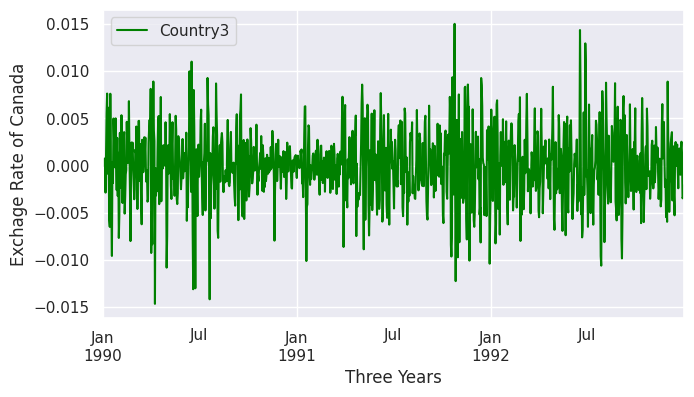

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(7.5,4)})
residual.iloc[0:1095].plot(y=['Country3'] ,color=['green'])

plt.ylabel('Exchage Rate of Canada')
plt.xlabel('Three Years')

plt.show()

In [ ]:
#Train Test Valid split
train_residual,test_residual = residual[0:6829], residual[6829:]
train_residual, valid_residual = residual[0:6146], residual[6146:6829]

In [ ]:
X_trainr, y_trainr = split_series(train_residual.values,n_past, n_future)
X_trainr = X_trainr.reshape((X_trainr.shape[0], X_trainr.shape[1],n_features))
y_trainr = y_trainr.reshape((y_trainr.shape[0], y_trainr.shape[1], n_features))
X_testr, y_testr = split_series(test_residual.values,n_past, n_future)
X_testr = X_testr.reshape((X_testr.shape[0], X_testr.shape[1],n_features))
y_testr = y_testr.reshape((y_testr.shape[0], y_testr.shape[1], n_features))
X_validr, y_validr = split_series(valid_residual.values,n_past, n_future)
X_validr = X_validr.reshape((X_validr.shape[0], X_validr.shape[1],n_features))
y_validr = y_validr.reshape((y_validr.shape[0], y_validr.shape[1], n_features))

6146
759
683


##Stacked GRU

In [ ]:
modelr = Sequential()
modelr.add(GRU(units=128,
                                 return_sequences=True,
                                 kernel_initializer = 'uniform',
                                 activation = 'tanh'
                                 ))
modelr.add(GRU(units=128,
                                 return_sequences=False,
                                 kernel_initializer = 'uniform',
                                 activation = 'tanh'
                                 ))
modelr.add(RepeatVector(n_future))
modelr.add(TimeDistributed(Dense(units=n_features, activation = None)))
modelr.compile(loss='mae', optimizer='adam')
modelr.build((None, n_past, n_features))
modelr.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_12 (ModuleWra (None, 24, 128)           52992     
_________________________________________________________________
module_wrapper_13 (ModuleWra (None, 128)               99072     
_________________________________________________________________
module_wrapper_14 (ModuleWra (None, 3, 128)            0         
_________________________________________________________________
module_wrapper_15 (ModuleWra (None, 3, 8)              1032      
Total params: 153,096
Trainable params: 153,096
Non-trainable params: 0
_________________________________________________________________


In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history=modelr.fit(X_trainr,y_trainr,epochs=20,validation_data=(X_validr,y_validr),batch_size=16,verbose=1,callbacks=[reduce_lr,es])

Epoch 1/20
383/383 [==============================] - 60s 133ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 2/20
383/383 [==============================] - 30s 77ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 3/20
383/383 [==============================] - 19s 50ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 4/20
383/383 [==============================] - 19s 50ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 5/20
383/383 [==============================] - 21s 54ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 6/20
383/383 [==============================] - 17s 46ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 7/20
383/383 [==============================] - 18s 48ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 8/20
383/383 [==============================] - 17s 46ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 9/20
383/383 [==============================] - 41s 106ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 10/20
383/383 [==============================] - 27s 70ms/step - loss: 0.0

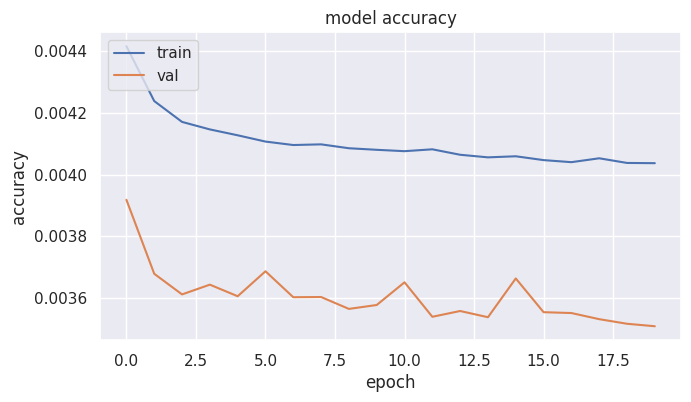

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
modelr.evaluate(X_testr,y_testr)

23/23 [==============================] - 1s 22ms/step - loss: 0.0040


0.003987354226410389

In [ ]:
predr = modelr.predict(X_testr)

In [ ]:
del(modelr)
del(X_testr)
del(X_trainr)
del(X_validr)
del(y_testr)
del(y_trainr)
del(y_validr)
del(residual)
gc.collect()

14813

**ADDITIVE DECOMPOSTION to COLLECT TREND**

In [ ]:
import statsmodels.api as sm
from matplotlib import rcParams

# Generate example time series data


# Decompose the time series into its trend, seasonal, and residual components using additive decomposition
trend= {}
for ts in df.columns:
    decomposition = sm.tsa.seasonal_decompose(dff[ts],model='additive')
    trend[ts] = decomposition.trend.copy()

trend=pd.DataFrame(trend)
trend.columns=Header
trend=trend.fillna(0)

del(decomposition)
gc.collect()

13554

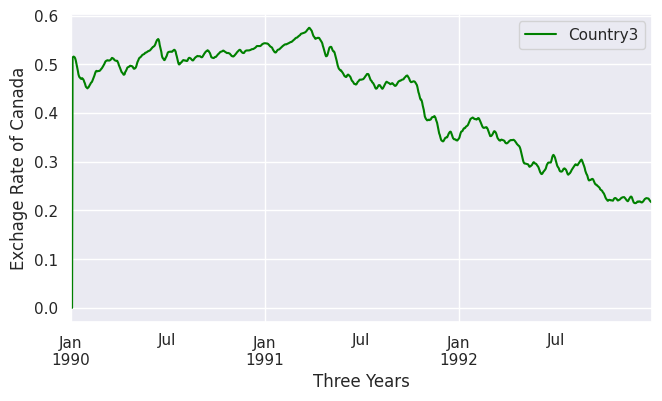

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(7.5,4)})
trend.iloc[0:1095].plot(y=['Country3'] ,color=['green'])

plt.ylabel('Exchage Rate of Canada')
plt.xlabel('Three Years')

plt.show()

In [ ]:
# Split the data into train and test and validation sets
train_trend,test_trend = trend[0:6829], trend[6829:]
train_trend, valid_trend = trend[0:6146], trend[6146:6829]

In [ ]:
X_traint, y_traint = split_series(train_trend.values,n_past, n_future)
X_traint = X_traint.reshape((X_traint.shape[0], X_traint.shape[1],n_features))
y_traint = y_traint.reshape((y_traint.shape[0], y_traint.shape[1], n_features))
X_testt, y_testt = split_series(test_trend.values,n_past, n_future)
X_testt = X_testt.reshape((X_testt.shape[0], X_testt.shape[1],n_features))
y_testt = y_testt.reshape((y_testt.shape[0], y_testt.shape[1], n_features))
X_validt, y_validt = split_series(valid_trend.values,n_past, n_future)
X_validt = X_validt.reshape((X_validt.shape[0], X_validt.shape[1],n_features))
y_validt = y_validt.reshape((y_validt.shape[0], y_validt.shape[1], n_features))

6146
759
683


##Attention LSTM


In [ ]:
modelt = Sequential()
modelt.add(LSTM(units=128,
                                 return_sequences=False,
                                 kernel_initializer = 'uniform',
                                 activation = 'tanh'
                                 ))
modelt.add(RepeatVector(n_future))
modelt.add(SeqSelfAttention(attention_activation = 'tanh'))
modelt.add(TimeDistributed(Dense(units=n_features, activation = None)))
modelt.compile(loss='mae', optimizer='adam')
modelt.build((None, n_past, n_features))
modelt.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_16 (ModuleWra (None, 128)               70144     
_________________________________________________________________
module_wrapper_17 (ModuleWra (None, 3, 128)            0         
_________________________________________________________________
module_wrapper_18 (ModuleWra (None, 3, 128)            8257      
_________________________________________________________________
module_wrapper_19 (ModuleWra (None, 3, 8)              1032      
Total params: 79,433
Trainable params: 79,433
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
#modelt.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_absolute_error')
history=modelt.fit(X_traint,y_traint,epochs=20,validation_data=(X_validt,y_validt),batch_size=16,verbose=1,callbacks=[reduce_lr,es])

Epoch 1/20
383/383 [==============================] - 12s 25ms/step - loss: 0.0394 - val_loss: 0.0483
Epoch 2/20
383/383 [==============================] - 9s 23ms/step - loss: 0.0149 - val_loss: 0.0199
Epoch 3/20
383/383 [==============================] - 10s 26ms/step - loss: 0.0128 - val_loss: 0.0259
Epoch 4/20
383/383 [==============================] - 8s 21ms/step - loss: 0.0107 - val_loss: 0.0177
Epoch 5/20
383/383 [==============================] - 10s 26ms/step - loss: 0.0098 - val_loss: 0.0158
Epoch 6/20
383/383 [==============================] - 10s 26ms/step - loss: 0.0090 - val_loss: 0.0163
Epoch 7/20
383/383 [==============================] - 8s 21ms/step - loss: 0.0087 - val_loss: 0.0140
Epoch 8/20
383/383 [==============================] - 10s 26ms/step - loss: 0.0080 - val_loss: 0.0137
Epoch 9/20
383/383 [==============================] - 9s 24ms/step - loss: 0.0076 - val_loss: 0.0158
Epoch 10/20
383/383 [==============================] - 9s 23ms/step - loss: 0.0072 - v

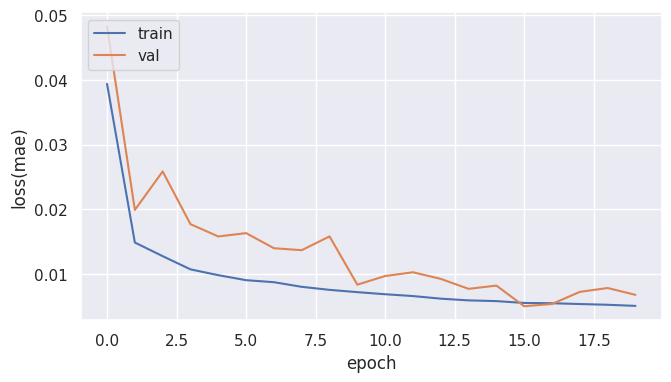

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss(mae)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
modelt.evaluate(X_testt,y_testt)

23/23 [==============================] - 0s 12ms/step - loss: 0.0082


0.008237900212407112

In [ ]:
predt = modelt.predict(X_testt)

In [ ]:
del(modelt)
del(X_testt)
del(X_traint)
del(X_validt)
del(y_testt)
del(y_traint)
del(y_validt)
del(trend)
gc.collect()

52448

**ADDITIVE DECOMPOSITION to COLLECT SEASONALITY**

In [ ]:
import statsmodels.api as sm
from matplotlib import rcParams

# Generate example time series data


# Decompose the time series into its trend, seasonal, and residual components using additive decomposition
residual = {}
seasonal ={}
trend= {}
d=0
for ts in df.columns:
    decomposition = sm.tsa.seasonal_decompose(dff[ts],model='additive')
    seasonal[ts] = decomposition.seasonal.copy()


seasonal=pd.DataFrame(seasonal)
seasonal.columns=Header
seasonal=seasonal.fillna(0)

del(decomposition)
gc.collect()

0

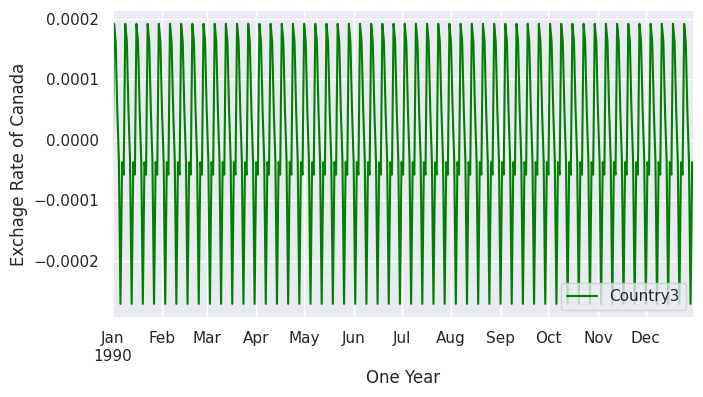

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(7.5,4)})
seasonal.iloc[0:365].plot(y=['Country3'] ,color=['green'])

plt.ylabel('Exchage Rate of Canada')
plt.xlabel('One Year')

plt.show()

In [ ]:
# Split the data into train and test sets
train_seasonal,test_seasonal = seasonal[0:6829], seasonal[6829:]
train_seasonal, valid_seasonal = seasonal[0:6146], seasonal[6146:6829]
print(train_seasonal.shape)
print(test_seasonal.shape)
print(valid_seasonal.shape)

(6146, 8)
(759, 8)
(683, 8)


In [ ]:
X_trains, y_trains = split_series(train_seasonal.values,n_past, n_future)
print(train_seasonal.values.shape)
print("train")
print(X_trains.shape)
print(y_trains.shape)
X_trains = X_trains.reshape((X_trains.shape[0], X_trains.shape[1],n_features))
y_trains = y_trains.reshape((y_trains.shape[0], y_trains.shape[1], n_features))
print("train after reshape")
print(X_trains.shape)
print(y_trains.shape)
X_tests, y_tests = split_series(test_seasonal.values,n_past, n_future)
print("test")
print(X_tests.shape)
print(y_tests.shape)
X_tests = X_tests.reshape((X_tests.shape[0], X_tests.shape[1],n_features))
y_tests = y_tests.reshape((y_tests.shape[0], y_tests.shape[1], n_features))
print("test after reshape")
print(X_tests.shape)
print(y_tests.shape)
X_valids, y_valids = split_series(valid_seasonal.values,n_past, n_future)
print("valid")
print(X_valids.shape)
print(y_valids.shape)
X_valids = X_valids.reshape((X_valids.shape[0], X_valids.shape[1],n_features))
y_valids = y_valids.reshape((y_valids.shape[0], y_valids.shape[1], n_features))
print("valid after reshape")
print(X_valids.shape)
print(y_valids.shape)

6146
(6146, 8)
train
(6120, 24, 8)
(6120, 3, 8)
train after reshape
(6120, 24, 8)
(6120, 3, 8)
759
test
(733, 24, 8)
(733, 3, 8)
test after reshape
(733, 24, 8)
(733, 3, 8)
683
valid
(657, 24, 8)
(657, 3, 8)
valid after reshape
(657, 24, 8)
(657, 3, 8)


##St-LSTM Enc-Dec

In [ ]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder = tf.keras.layers.LSTM(100, activation='relu', return_state=True)
encoder_outputs = encoder(encoder_inputs)
encoder_states = encoder_outputs[1:]
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs[0])

decoder = tf.keras.layers.LSTM(100, activation='relu',return_sequences=True)(decoder_inputs,initial_state = encoder_states)
#decoder_l2 = tf.keras.layers.LSTM(80, activation='relu',return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder)

models = tf.keras.models.Model(encoder_inputs,decoder_outputs)

models.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 24, 8)]      0           []                               
                                                                                                  
 lstm_4 (LSTM)                  [(None, 100),        43600       ['input_2[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector_6 (RepeatVector)  (None, 3, 100)      0           ['lstm_4[0][0]']                 
                                                                                            

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
models.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_absolute_error')
history=models.fit(X_trains,y_trains,epochs=20,validation_data=(X_valids,y_valids),batch_size=16,verbose=1,callbacks=[reduce_lr,es])

Epoch 1/20
383/383 [==============================] - 13s 26ms/step - loss: 2.3151e-04 - val_loss: 1.9735e-04 - lr: 0.0010
Epoch 2/20
383/383 [==============================] - 8s 21ms/step - loss: 2.0316e-04 - val_loss: 1.8549e-04 - lr: 0.0010
Epoch 3/20
383/383 [==============================] - 9s 24ms/step - loss: 1.8807e-04 - val_loss: 1.6937e-04 - lr: 0.0010
Epoch 4/20
383/383 [==============================] - 10s 25ms/step - loss: 1.7138e-04 - val_loss: 1.7187e-04 - lr: 0.0010
Epoch 5/20
383/383 [==============================] - 8s 20ms/step - loss: 1.5862e-04 - val_loss: 1.3807e-04 - lr: 0.0010
Epoch 6/20
383/383 [==============================] - 10s 25ms/step - loss: 1.4699e-04 - val_loss: 1.4082e-04 - lr: 0.0010
Epoch 7/20
383/383 [==============================] - 8s 22ms/step - loss: 1.4079e-04 - val_loss: 1.3913e-04 - lr: 0.0010
Epoch 8/20
383/383 [==============================] - 9s 24ms/step - loss: 1.3189e-04 - val_loss: 1.4129e-04 - lr: 0.0010
Epoch 9/20
383/383 [=

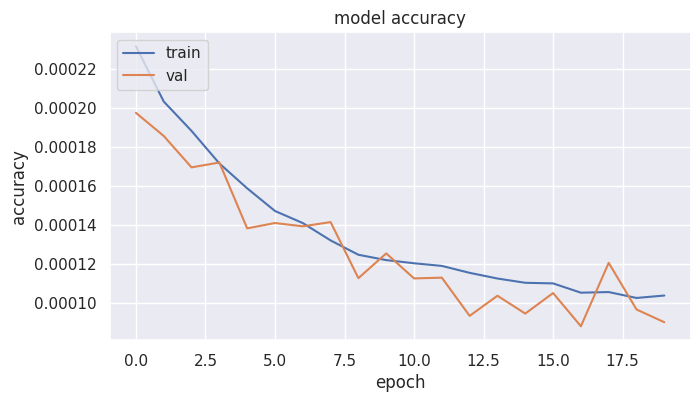

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
models.evaluate(X_tests,y_tests)

23/23 [==============================] - 0s 8ms/step - loss: 8.9856e-05


8.985554450191557e-05

In [ ]:
preds = models.predict(X_tests)

23/23 [==============================] - 1s 11ms/step


In [ ]:
del(models)
del(X_tests)
del(X_trains)
del(X_valids)
del(y_tests)
del(y_trains)
del(y_valids)
del(seasonal)
gc.collect()

34101

##Prediction Fusion

In [ ]:
pred = preds + predt + predr
print(pred.shape)

(733, 3, 8)


In [ ]:
train,test = df[0:6829], df[6829:]
train, valid = df[0:6146], df[6146:6829]

In [ ]:
X_train, y_train = split_series(train.values,n_past, n_future)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split_series(valid.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))
print(X_test.shape)
print(y_test.shape)

6146
759
683
(733, 24, 8)
(733, 3, 8)


In [ ]:
mean_array = dff.mean(axis = 0)
y_test_std = np.zeros((y_test.shape[0],y_test.shape[1],y_test.shape[2]))
#y_tst = np.zeros((y_test.shape[0],y_test.shape[1],y_test.shape[2]))
#y_tst =  y_test.mean(axis = 1)
for i in range(y_test.shape[0]):
  for j in range(y_test.shape[1]):
    y_test_std[i][j] = (y_test[i][j] - mean_array)* (y_test[i][j] - mean_array) #n x n_future x num_user

y_test_sum = y_test_std.mean(axis = 1) # n x num_user

##RSE & RSquare

In [ ]:
diff = np.zeros((y_test.shape[0],y_test.shape[1],y_test.shape[2]))
diff = (y_test-pred)*(y_test-pred)
diff_sum = diff.mean(axis = 1)


diff_ = diff_sum.mean(axis = 1)
y_ = y_test_sum.mean(axis = 1)
diff__ = diff_.sum()
y__ = y_.sum()
rsquare = 1 - (diff__/y__)
rse = np.sqrt(diff__)/np.sqrt(y__)
print(rse)
print(rsquare)

0.06184347348002717
0.9961753847879252


In [ ]:
squared_diff_actual_pred = np.square(y_test - pred)

# Calculate squared differences between actual matrix and mean of actual matrix
mean_actual = np.mean(y_test)
squared_diff_actual_mean = np.square(y_test - mean_actual)

# Sum squared differences along all elements
sum_squared_diff_actual_pred = np.sum(squared_diff_actual_pred)
sum_squared_diff_actual_mean = np.sum(squared_diff_actual_mean)

# Calculate RSE
rse = np.sqrt(sum_squared_diff_actual_pred / sum_squared_diff_actual_mean)

print("Root Relative Squared Error (RSE):", rse)

Root Relative Squared Error (RSE): 0.06234038330596009


In [ ]:
actual_flat = y_test.flatten()
prediction_flat = pred.flatten()

# Calculate squared differences between actual and prediction values
squared_diff = np.square(actual_flat - prediction_flat)

# Calculate squared differences between actual values and mean of actual values
mean_actual = np.mean(actual_flat)
squared_diff_actual_mean = np.square(actual_flat - mean_actual)

# Sum squared differences along all elements
sum_squared_diff_actual_pred = np.sum(squared_diff)
sum_squared_diff_actual_mean = np.sum(squared_diff_actual_mean)

# Calculate RSE
rse = np.sqrt(sum_squared_diff_actual_pred / sum_squared_diff_actual_mean)

print("Root Relative Squared Error (RSE) with flattened matrices:", rse)

Root Relative Squared Error (RSE) with flattened matrices: 0.06234038330596009


In [ ]:
rmse = np.sqrt(np.mean((y_test - pred)**2))

# Calculate range of true values
denom=np.sqrt(np.mean((y_test - np.mean(y_test))**2))
rrse = rmse / denom
print("Root Relative Squared Error (RRSE):", rrse)

Root Relative Squared Error (RRSE): 0.0623403833059601


##CORR


#corr using function

In [ ]:
flat_matrix_1 =y_test.flatten()
flat_matrix_2 = pred.flatten()

# Calculate the correlation coefficient between the flattened arrays
correlation = np.corrcoef(flat_matrix_1, flat_matrix_2)[0, 1]

print("Correlation between the two 3D matrices:", correlation)



Correlation between the two 3D matrices: 0.9983942501095215


#corr according to lstnet

In [ ]:
y_true_mean= np.mean(y_test,axis=(1),keepdims=True)
# print(y_true_mean.shape)
y_pred_mean = np.mean(pred, axis=(1),keepdims=True)
# print(y_pred_mean.shape)

#for num
# print("num")
y_true_diff = y_test - y_true_mean
# print(y_true_diff.shape)

y_pred_diff = pred - y_pred_mean
# print(y_true_diff.shape)

sum_product_diff = y_true_diff * y_pred_diff
# print(sum_product_diff.shape)

num= np.sum(sum_product_diff,axis=1,keepdims=True)
# print(num.shape)

# print("")
# print("denom")
#for denom
y_true_diff_squared=y_true_diff**2
# print(y_true_diff_squared.shape)

y_pred_diff_squared =y_pred_diff**2
# print(y_true_diff_squared.shape)

sum_product_diff_squared = y_true_diff_squared * y_pred_diff_squared
# print(sum_product_diff_squared.shape)

denom_squared= np.sum(sum_product_diff_squared,axis=1,keepdims=True)
# print(denom_squared.shape)

denom=np.sqrt(denom_squared)
# print(denom.shape)
#division
# print("division")
eps = 1e-8
division= num/(denom+eps)
# print(division.shape)


print("corr")
corr_test=np.mean(division,axis=0)
# print(corr_test.shape)
# print(corr_test)
corr_final=np.mean(corr_test)

print(corr_final)




corr
0.039154714578130974


##MAE

In [ ]:
dif = np.zeros((y_test.shape[0],y_test.shape[1],y_test.shape[2]))
dif = np.abs(y_test-pred)
dif_sum = dif.mean(axis = 1)


dif_ = dif_sum.mean(axis = 1)
dif__ = dif_.sum()
print(dif__/y_test.shape[0])

0.008373024886493809


##SMAPE

In [ ]:
top = np.zeros((y_test.shape[0],y_test.shape[1],y_test.shape[2]))
top = np.abs(y_test-pred)
bottom = (np.abs(y_test)+np.abs(pred))/2
val = top/bottom
val_ = val.mean(axis = 1)
val__ = val_.mean(axis = 1)
val___ = val__.sum()
smap = ((val___)/y_test.shape[0])
print(smap)

0.02332124267902109


##Plot predic vs actual

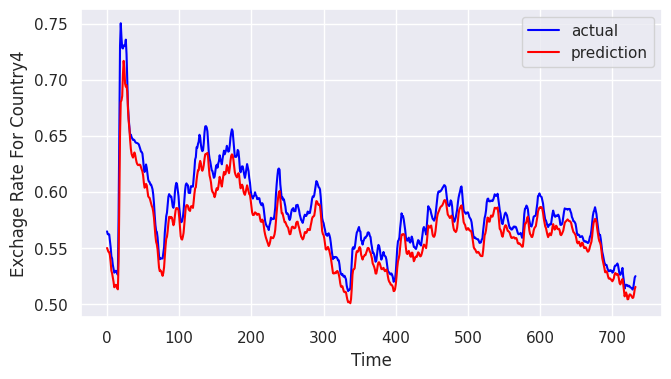

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(7.5,4)})

meanpred = np.zeros((y_test.shape[0],y_test.shape[1],y_test.shape[2]))
meanpred = pred.mean(axis=1)

b = pd.DataFrame(y_test.mean(axis=1))
b.columns = Header
b=b.iloc[0:1000][:]
plt.plot(b['Country4'],label="actual",color='blue')

a = pd.DataFrame(meanpred)
a.columns = Header
a=a.iloc[0:1000][:]
plt.plot(a['Country4'],label="prediction",color='red')


plt.ylabel('Exchage Rate For Country4')
plt.xlabel('Time')
plt.legend()
#plt.show()